In [21]:
# libraries
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow import math as TFmath
import math,os,shutil
from prettytable import PrettyTable
import scipy.stats as stats
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
tf.random.set_seed(256)


TensorFlow version: 2.20.0


In [22]:
# libraries
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow import math as TFmath
import math,os,shutil
from prettytable import PrettyTable
import scipy.stats as stats
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
tf.random.set_seed(256)


TensorFlow version: 2.20.0


In [23]:
# Full paths to training data
TRAIN_FEATURE_PATH = "../Features/Train/COSMOS_features.csv"
TRAIN_LABEL_PATH   = "../Features/Train/COSMOS_labels.csv"

# Full path to test data
TEST_FEATURE_PATH = "../Features/Test/test_features0.csv"

# Output folders
figure_prepath = "../figures/"
model_prepath = "../model/"

# Create output folders if not existed
os.makedirs(figure_prepath, exist_ok=True)
os.makedirs(model_prepath, exist_ok=True)

# Plotting configuration
figureFrontSize = 12
figureName_post = "_test.png"


In [24]:
### helper labels - fixed
Numchannels = 95
num_inputFeatures = Numchannels * 2 + 6 # target_gain, target_gain_tilt, EDFA_input_power_total, EDFA_output_power_total
labels = {"gainValue":'target_gain',
          "EDFA_input":'EDFA_input_power_total',
          "EDFA_output":'EDFA_output_power_total',
          "inSpectra":'EDFA_input_spectra_',
          "WSS":'DUT_WSS_activated_channel_index_',
          "result":'calculated_gain_spectra_'}
inSpectra_labels = [labels['inSpectra']+str(i).zfill(2) for i in range(0,Numchannels)]
onehot_labels = [labels['WSS']+str(i).zfill(2) for i in range(0,Numchannels)]
result_labels = [labels['result']+str(i).zfill(2) for i in range(0,Numchannels)]
preProcess_labels = [labels['EDFA_input'],labels['EDFA_output']]
preProcess_labels.extend(inSpectra_labels)

In [25]:
def dB_to_linear(data):
  return np.power(10,data/10)

def linear_TO_Db(data):
  result = 10*np.log10(data).to_numpy()
  return result[result != -np.inf]

def linear_TO_Db_full(data):
  result = 10*np.log10(data).to_numpy()
  result[result == -np.inf] = 0
  return result

def divideZero(numerator,denominator):
  with np.errstate(divide='ignore'):
    result = numerator / denominator
    result[denominator == 0] = 0
  return result

In [26]:
### train and loss function
def custom_loss(y_actual,y_pred):
  # calculate the loaded channel numbers for each batch
  # batch default is [batch size=32, outputchannel number]
  loaded_size = tf.dtypes.cast(TFmath.count_nonzero(y_actual), tf.float32)
  # turn unloaded y_pred prediction to zero
  y_pred_cast_unloaded_to_zero = TFmath.divide_no_nan(TFmath.multiply(y_pred,y_actual),y_actual)
  # error [unloaded,unloaded,loaded,loaded]: y_pred = [13->0,15->0,18.5,18.3], y_actual = [0,0,18.2,18.2]
  error = TFmath.abs(TFmath.subtract(y_pred_cast_unloaded_to_zero,y_actual))
  # custom_loss = (0.3+0.2) / 2
  custom_loss = TFmath.divide(TFmath.reduce_sum(error),loaded_size)
  return custom_loss

def custom_loss_L2(y_actual,y_pred):
  loaded_size = tf.dtypes.cast(TFmath.count_nonzero(y_actual), tf.float32)
  y_pred_cast_unloaded_to_zero = TFmath.divide_no_nan(TFmath.multiply(y_pred,y_actual),y_actual)
  error = TFmath.square(TFmath.subtract(y_pred_cast_unloaded_to_zero,y_actual))
  custom_loss = TFmath.sqrt(TFmath.divide(TFmath.reduce_sum(error),loaded_size))
  return custom_loss
    

In [ ]:
from tensorflow.keras import regularizers

def designed_DNN_model(outputNum, input_dim):
    model = keras.Sequential([
        # Hidden Layer 1
        layers.Dense(512, input_dim=input_dim,
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.LeakyReLU(alpha=0.1),

        # Hidden Layer 2
        layers.Dense(256,
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.LeakyReLU(alpha=0.1),

        # Hidden Layer 3
        layers.Dense(128,
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.2),

        # Output Layer
        layers.Dense(outputNum, activation='linear'),
    ])

    model.compile(
        loss=custom_loss_L2,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001)
    )
    return model




### debug function after train -> go to csv
def plot_loss(indx,history,ingnoreIndex):
    plt.figure(indx)
    plt.plot(history.history['loss'][ingnoreIndex:], label='loss')
    plt.plot(history.history['val_loss'][ingnoreIndex:], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [gain]')
    plt.legend()
    plt.grid(True)

def figure_comp(figIndx,y_test_result,y_pred_result,filename,setFrontSize):
    plt.figure(figIndx)
    plt.axes(aspect='equal')
    plt.scatter(y_test_result, y_pred_result)
    plt.xlabel('Measured EDFA Gain (dB)', fontsize=setFrontSize)
    plt.ylabel('predicted EDFA Gain (dB)', fontsize=setFrontSize)
    minAxis = math.floor(min(y_test_result.min(),y_pred_result.min()) - 0.5)
    maxAxis = math.ceil (max(y_test_result.max(),y_pred_result.max()) + 0.5)
    # print(min(y_test_result.min(),y_pred_result.min()),max(y_test_result.max(),y_pred_result.max()))
    # print(minAxis,maxAxis)
    limss = [*np.arange(minAxis,maxAxis+1,1)]
    lims = [limss[0],limss[-1]]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims, 'k--')
    plt.xticks(ticks=limss,labels=limss,fontsize=setFrontSize)
    plt.yticks(fontsize=setFrontSize)
    plt.savefig(figure_prepath+filename, dpi=900)

def figure_hist(figIndx,error,filename,setFrontSize):
    plt.figure(figIndx)
    bins_list = [*np.arange(-0.6,0.7,0.1)]
    labelList = ['-0.6','','-0.4','','-0.2','','0.0','','0.2','','0.4','','0.6']
    plt.hist(error, bins=bins_list)
    for i in [-0.2,-0.1,0.1,0.2]: # helper vertical line
        plt.axvline(x=i,color='black',ls='--')
    plt.xlabel('Prediction Gain Error (dB)', fontsize=setFrontSize)
    plt.ylabel('Histogram', fontsize=setFrontSize)
    plt.xticks(ticks=bins_list, labels=labelList, fontsize=setFrontSize)
    plt.yticks(fontsize=setFrontSize)
    plt.savefig(figure_prepath+filename, dpi=900)

def plot_per_channel_error(y_pred,y_test):
    y_pred_result = linear_TO_Db_full(y_pred)
    y_test_result = linear_TO_Db_full(y_test)
    error = y_test_result - y_pred_result
    error_min_0_1s,error_means,error_min_0_2s,within95ranges,mses = [],[],[],[],[]
    for j in range(len(error[0])):
        error_channel = error[:,j]
        error_channel = error_channel[error_channel!=0]
        # calculate the distribution
        error_reasonable = [i for i in error_channel if abs(i)<=0.2]
        error_measureError = [i for i in error_channel if abs(i)<=0.1]
        error_min_0_1 = len(error_measureError)/len(error_channel)
        error_min_0_2 = len(error_reasonable)/len(error_channel)
        error_sorted = np.sort(abs(error_channel))
        within95range = error_sorted[int(0.95*len(error_channel))]
        mse = (np.square(error_channel)).mean(axis=None)
        error_mean = error_channel.mean(axis=None)
        error_means.append(error_mean)
        error_min_0_1s.append(error_min_0_1)
        error_min_0_2s.append(error_min_0_2)
        within95ranges.append(within95range)
        mses.append(mse)
    # plt.figure(100)
    # plt.plot(error_min_0_1s)
    # plt.figure(101)
    # plt.plot(error_min_0_2s)
    # plt.figure(102)
    # plt.plot(within95ranges)
    # plt.figure(104)
    # plt.plot(error_means)
    plt.figure(103)
    plt.plot(mses)
    plt.xlabel('Channel indices')
    plt.ylabel('MSE (dB^2)')
    plt.title("Per channel MSE")
      
def getErrorInfo(error):
    error_reasonable = [i for i in error if abs(i)<=0.2]
    error_measureError = [i for i in error if abs(i)<=0.1]
    # error_95 = [i for i in error if abs(i)<=0.25]
    error_min_0_1 = len(error_measureError)/len(error)
    error_min_0_2 = len(error_reasonable)/len(error)
    # error_min_0_25= len(error_95)/len(error)
    # error_max_0_2 = 1-len(error_reasonable)/len(error)
    error_sorted = np.sort(abs(error))
    within95range = error_sorted[int(0.95*len(error))]
    mse = (np.square(error)).mean(axis=None)
    return_error_min_0_1 = "{:.2f}".format(error_min_0_1)
    return_error_min_0_2 = "{:.2f}".format(error_min_0_2)
    return_within95range = "{:.2f}".format(within95range)
    return_mse = "{:.2f}".format(mse)
    return return_error_min_0_1,return_error_min_0_2,return_within95range,return_mse

In [ ]:
from tensorflow.keras import regularizers

def designed_DNN_model(outputNum, input_dim):
    model = keras.Sequential([
        layers.Dense(256, input_dim=input_dim,
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(128,
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.LeakyReLU(alpha=0.1),
        layers.Dense(128,
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.2),
        layers.Dense(128,
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.2),
        layers.Dense(outputNum, activation='linear'),
    ])

    model.compile(
        loss=custom_loss_L2,
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001)
    )
    return model


In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_train = pd.read_csv(TRAIN_FEATURE_PATH).iloc[:, 1:]
y_train = pd.read_csv(TRAIN_LABEL_PATH)
y_train.fillna(0, inplace=True)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
TrainModelName = model_prepath + "/ML_example_model.h5"
base_model = designed_DNN_model(Numchannels, X_train_scaled.shape[1])

history_dnn = base_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    verbose=2,
    epochs=1000,
)
base_model.save(TrainModelName)


Epoch 1/1000


c:\Users\gjw\.conda\envs\deeplearning\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\gjw\.conda\envs\deeplearning\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3466/3466 - 6s - 2ms/step - loss: 2.4474 - val_loss: 1.1033
Epoch 2/1000
3466/3466 - 5s - 1ms/step - loss: 1.4129 - val_loss: 0.3583
Epoch 3/1000
3466/3466 - 5s - 1ms/step - loss: 1.1445 - val_loss: 0.3518
Epoch 4/1000
3466/3466 - 5s - 1ms/step - loss: 0.9874 - val_loss: 0.6567
Epoch 5/1000
3466/3466 - 5s - 1ms/step - loss: 0.8998 - val_loss: 0.3519
Epoch 6/1000
3466/3466 - 5s - 1ms/step - loss: 0.8644 - val_loss: 0.3152
Epoch 7/1000
3466/3466 - 5s - 1ms/step - loss: 0.8370 - val_loss: 0.3336
Epoch 8/1000
3466/3466 - 5s - 1ms/step - loss: 0.8172 - val_loss: 0.3336
Epoch 9/1000
3466/3466 - 5s - 1ms/step - loss: 0.7932 - val_loss: 0.2907
Epoch 10/1000
3466/3466 - 5s - 1ms/step - loss: 0.7748 - val_loss: 0.3729
Epoch 11/1000
3466/3466 - 5s - 1ms/step - loss: 0.7490 - val_loss: 0.3362
Epoch 12/1000
3466/3466 - 5s - 1ms/step - loss: 0.7369 - val_loss: 0.2911
Epoch 13/1000
3466/3466 - 5s - 1ms/step - loss: 0.7172 - val_loss: 0.2798
Epoch 14/1000
3466/3466 - 5s - 1ms/step - loss: 0.7024 - val

In [38]:
history_dnn = base_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    verbose=2,
    epochs=100,
    # callbacks=[callback]
)


base_model.save(TrainModelName)

Epoch 1/100
3466/3466 - 7s - 2ms/step - loss: 0.1047 - val_loss: 0.2848
Epoch 2/100
3466/3466 - 7s - 2ms/step - loss: 0.1069 - val_loss: 0.3206
Epoch 3/100
3466/3466 - 7s - 2ms/step - loss: 0.1087 - val_loss: 0.2957
Epoch 4/100
3466/3466 - 7s - 2ms/step - loss: 0.1075 - val_loss: 0.3070
Epoch 5/100
3466/3466 - 7s - 2ms/step - loss: 0.1081 - val_loss: 0.3046
Epoch 6/100
3466/3466 - 7s - 2ms/step - loss: 0.1068 - val_loss: 0.3234
Epoch 7/100
3466/3466 - 7s - 2ms/step - loss: 0.1070 - val_loss: 0.2814
Epoch 8/100
3466/3466 - 7s - 2ms/step - loss: 0.1052 - val_loss: 0.2965
Epoch 9/100
3466/3466 - 7s - 2ms/step - loss: 0.1069 - val_loss: 0.3205
Epoch 10/100
3466/3466 - 7s - 2ms/step - loss: 0.1067 - val_loss: 0.3131
Epoch 11/100
3466/3466 - 7s - 2ms/step - loss: 0.1062 - val_loss: 0.3132
Epoch 12/100
3466/3466 - 7s - 2ms/step - loss: 0.1067 - val_loss: 0.6163
Epoch 13/100
3466/3466 - 7s - 2ms/step - loss: 0.1052 - val_loss: 0.3177
Epoch 14/100
3466/3466 - 7s - 2ms/step - loss: 0.1092 - val_

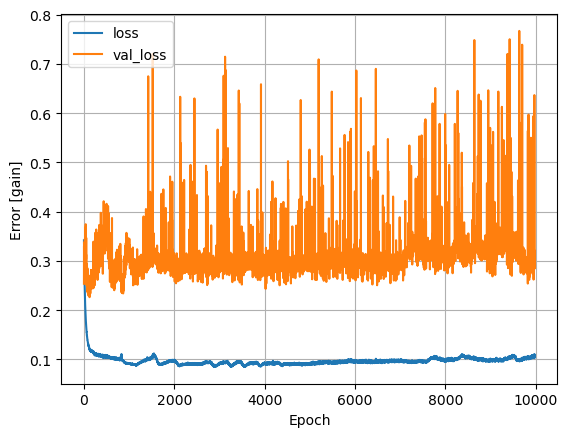

In [36]:
plot_loss(1, history_dnn, 15)

In [ ]:
X_test_full = pd.read_csv(TEST_FEATURE_PATH)
X_test = X_test_full.iloc[:, 3:]
X_test_scaled = scaler.transform(X_test)
y_pred_array = base_model.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred_array, columns=y_train.columns)

wss_cols = [col for col in X_test.columns if 'dut_wss_activated_channel_index' in col.lower()]
label_cols = [col for col in y_train.columns if 'calculated_gain_spectra' in col.lower()]

mask = X_test[wss_cols].values == 1
y_pred = pd.DataFrame(np.where(mask, y_pred.values, np.nan),
    columns=label_cols
)

y_pred.fillna(0, inplace=True)

kaggle_ID = X_test_full.columns[0]
y_pred.insert(0, kaggle_ID, X_test_full[kaggle_ID].values)

output_path = "../Features/Test/example_submission.csv"
y_pred.to_csv(output_path, index=False)


658/658 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step
